In [ ]:
!pip install cmfrec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.6/267.6 KB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.20-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1-cp39-cp39-linux_x86_64.whl size=5779190 sha256=524955b491347441a365150aab51319c759b1192c4453ef59a17e66192b81bc9
  Stored in directory: /root/.cache/pip/wheels/1e/e8/73/c1bd3e49c18c766be4f1e8ff615d21709bf3bbc815552a5ab2
Successfully built cmfrec


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "gdrive/MyDrive/Articulo"

Mounted at /content/gdrive
user_topo_proper_expo_0.csv   user_topo_proper_pow_55.csv
user_topo_proper_expo_10.csv  user_topo_proper_pow_56.csv
user_topo_proper_expo_11.csv  user_topo_proper_pow_57.csv
user_topo_proper_expo_12.csv  user_topo_proper_pow_58.csv
user_topo_proper_expo_13.csv  user_topo_proper_pow_59.csv
user_topo_proper_expo_14.csv  user_topo_proper_pow_5.csv
user_topo_proper_expo_15.csv  user_topo_proper_pow_60.csv
user_topo_proper_expo_16.csv  user_topo_proper_pow_61.csv
user_topo_proper_expo_17.csv  user_topo_proper_pow_62.csv
user_topo_proper_expo_18.csv  user_topo_proper_pow_63.csv
user_topo_proper_expo_19.csv  user_topo_proper_pow_64.csv
user_topo_proper_expo_1.csv   user_topo_proper_pow_65.csv
user_topo_proper_expo_20.csv  user_topo_proper_pow_66.csv
user_topo_proper_expo_21.csv  user_topo_proper_pow_67.csv
user_topo_proper_expo_22.csv  user_topo_proper_pow_68.csv
user_topo_proper_expo_23.csv  user_topo_proper_pow_69.csv
user_topo_proper_expo_24.csv  user_topo_proper

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmfrec import CMF
import statistics as st
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
df_ratings = pd.read_csv('gdrive/MyDrive/Datasets/ratings_small.csv', usecols=[0, 1, 2])
M = df_ratings['UserId'].nunique()
N = df_ratings['ItemId'].nunique()
movie_mapper = dict(zip(np.unique(df_ratings["ItemId"]), list(range(0,N))))
user_mapper = dict(zip(np.unique(df_ratings["UserId"]), list(range(0,M))))
movie_inv_mapper = dict(zip(list(range(0,N)), np.unique(df_ratings["ItemId"])))
user_inv_mapper = dict(zip(list(range(N,N+M)), np.unique(df_ratings["UserId"])))

df_ratings['UserId'] = df_ratings['UserId'].apply(lambda x: user_mapper[x])
df_ratings['ItemId'] = df_ratings['ItemId'].apply(lambda x: movie_mapper[x])

In [ ]:
df_ratings.describe()

,UserId,ItemId,Rating
count,100004.000000,100004.000000,100004.000000
mean,346.011310,2691.887445,3.543608
std,195.163838,2375.936209,1.058064
min,0.000000,0.000000,0.500000
25%,181.000000,832.000000,3.000000
50%,366.000000,1916.500000,4.000000
75%,519.000000,4121.000000,4.000000
max,670.000000,9065.000000,5.000000


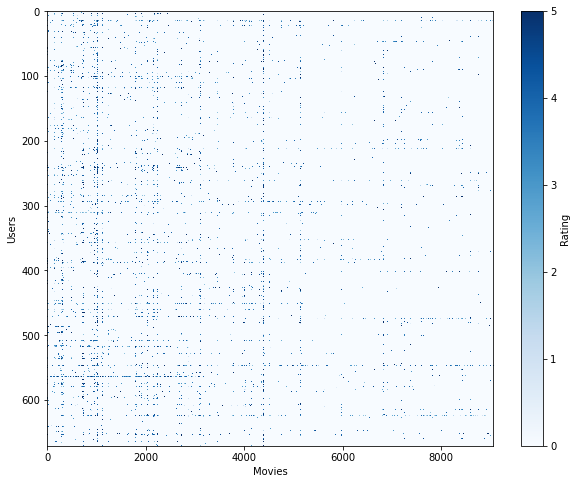

In [ ]:
from scipy.sparse import csr_matrix
row = df_ratings['UserId'].tolist()
col = df_ratings['ItemId'].tolist()
data = df_ratings['Rating'].tolist()
R = csr_matrix((data, (row, col)))
d=R.todense()
plt.figure(figsize = (10,8))
plt.imshow(d,interpolation='none',cmap='Blues', aspect='auto')
plt.xlabel("Movies")
plt.ylabel("Users")
#plt.title("Rating Matrix")
cb = plt.colorbar()
cb.set_label('Rating')
plt.show()


In [ ]:
models = 100
k = 20
lambda_ = 10

In [ ]:
#Exponential model

h_rmse_expo, h_mae_expo, h_r2_expo = [], [], []
for i in range(models):
  filename = f"gdrive/MyDrive/Articulo/user_topo_proper_expo_{i}.csv"
  df_users = pd.read_csv(filename)
  #Normalize values
  df_users['degree'] = preprocessing.scale(df_users['degree'])
  df_users['betweenness'] = preprocessing.scale(df_users['betweenness'])
  df_users['community'] = preprocessing.scale(df_users['community'])
  df_users['eccentricity'] = preprocessing.scale(df_users['eccentricity'])
  df_users['farness'] = preprocessing.scale(df_users['farness'])
  #Train-Test Split Dataset
  users_train, users_test = train_test_split(df_ratings.UserId.unique(), test_size=0.2)
  items_train, items_test = train_test_split(df_ratings.ItemId.unique(), test_size=0.2)
  ratings_train, ratings_test = train_test_split(df_ratings.loc[df_ratings.UserId.isin(users_train) & df_ratings.ItemId.isin(items_train)], test_size=0.2)
  user_attr_train = df_users.loc[df_users.UserId.isin(ratings_train.UserId.unique())]

  #Fit Model
  m_collective = CMF(method="als", k=k, lambda_=lambda_, user_bias=True, verbose=False).fit(X=ratings_train, U=user_attr_train)

  #Predictions
  predictions = m_collective.predict(ratings_test.UserId, ratings_test.ItemId)

  #Metrics
  rmse = metrics.mean_squared_error(ratings_test.Rating,predictions,squared=True)
  mae = metrics.mean_absolute_error(ratings_test.Rating,predictions)
  r2 = metrics.r2_score(ratings_test.Rating,predictions)
  h_rmse_expo.append(rmse)
  h_mae_expo.append(mae)
  h_r2_expo.append(r2)

#Algorithm analysis
mean_h_rmse = st.mean(h_rmse_expo)
mean_h_mae = st.mean(h_mae_expo)
mean_h_r2 = st.mean(h_r2_expo)
stdev_h_rmse = st.stdev(h_rmse_expo)
stdev_h_mae = st.stdev(h_mae_expo)
stdev_h_r2 = st.stdev(h_r2_expo)
print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse,mean_h_mae,mean_h_r2))
print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))
print()

Mean of RMSE, MAE, R2: 0.786781369588039, 0.6833345290475219, 0.29596741251783965
Standard deviation of RMSE, MAE, R2: 0.015510297645192716, 0.007432699032455575, 0.010351479728094531



In [ ]:
#Power-law model

h_rmse_pow, h_mae_pow, h_r2_pow = [], [], []
for i in range(models):
  filename = f"gdrive/MyDrive/Articulo/user_topo_proper_pow_{i}.csv"
  df_users = pd.read_csv(filename)
  #Normalize values
  df_users['degree'] = preprocessing.scale(df_users['degree'])
  df_users['betweenness'] = preprocessing.scale(df_users['betweenness'])
  df_users['community'] = preprocessing.scale(df_users['community'])
  df_users['eccentricity'] = preprocessing.scale(df_users['eccentricity'])
  df_users['farness'] = preprocessing.scale(df_users['farness'])
  #Train-Test Split Dataset
  users_train, users_test = train_test_split(df_ratings.UserId.unique(), test_size=0.2)
  items_train, items_test = train_test_split(df_ratings.ItemId.unique(), test_size=0.2)
  ratings_train, ratings_test = train_test_split(df_ratings.loc[df_ratings.UserId.isin(users_train) & df_ratings.ItemId.isin(items_train)], test_size=0.2)
  user_attr_train = df_users.loc[df_users.UserId.isin(ratings_train.UserId.unique())]

  #Fit Model
  m_collective = CMF(method="als", k=k, lambda_=lambda_, user_bias=True, verbose=False).fit(X=ratings_train, U=user_attr_train)

  #Predictions
  predictions = m_collective.predict(ratings_test.UserId, ratings_test.ItemId)

  #Metrics
  rmse = metrics.mean_squared_error(ratings_test.Rating,predictions,squared=True)
  mae = metrics.mean_absolute_error(ratings_test.Rating,predictions)
  r2 = metrics.r2_score(ratings_test.Rating,predictions)
  h_rmse_pow.append(rmse)
  h_mae_pow.append(mae)
  h_r2_pow.append(r2)

#Algorithm analysis
mean_h_rmse = st.mean(h_rmse_pow)
mean_h_mae = st.mean(h_mae_pow)
mean_h_r2 = st.mean(h_r2_pow)
stdev_h_rmse = st.stdev(h_rmse_pow)
stdev_h_mae = st.stdev(h_mae_pow)
stdev_h_r2 = st.stdev(h_r2_pow)
print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse,mean_h_mae,mean_h_r2))
print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))
print()

Mean of RMSE, MAE, R2: 0.7887915450587072, 0.6842105663340518, 0.2948364435203696
Standard deviation of RMSE, MAE, R2: 0.017189113504299653, 0.008395568012016614, 0.010605378729101372



In [ ]:
#Rayleigh model

h_rmse_ray, h_mae_ray, h_r2_ray = [], [], []
for i in range(models):
  filename = f"gdrive/MyDrive/Articulo/user_topo_proper_pow_{i}.csv"
  df_users = pd.read_csv(filename)
  #Normalize values
  df_users['degree'] = preprocessing.scale(df_users['degree'])
  df_users['betweenness'] = preprocessing.scale(df_users['betweenness'])
  df_users['community'] = preprocessing.scale(df_users['community'])
  df_users['eccentricity'] = preprocessing.scale(df_users['eccentricity'])
  df_users['farness'] = preprocessing.scale(df_users['farness'])
  #Train-Test Split Dataset
  users_train, users_test = train_test_split(df_ratings.UserId.unique(), test_size=0.2)
  items_train, items_test = train_test_split(df_ratings.ItemId.unique(), test_size=0.2)
  ratings_train, ratings_test = train_test_split(df_ratings.loc[df_ratings.UserId.isin(users_train) & df_ratings.ItemId.isin(items_train)], test_size=0.2)
  user_attr_train = df_users.loc[df_users.UserId.isin(ratings_train.UserId.unique())]

  #Fit Model
  m_collective = CMF(method="als", k=k, lambda_=lambda_, user_bias=True, verbose=False).fit(X=ratings_train, U=user_attr_train)

  #Predictions
  predictions = m_collective.predict(ratings_test.UserId, ratings_test.ItemId)

  #Metrics
  rmse = metrics.mean_squared_error(ratings_test.Rating,predictions,squared=True)
  mae = metrics.mean_absolute_error(ratings_test.Rating,predictions)
  r2 = metrics.r2_score(ratings_test.Rating,predictions)
  h_rmse_ray.append(rmse)
  h_mae_ray.append(mae)
  h_r2_ray.append(r2)

#Algorithm analysis
mean_h_rmse = st.mean(h_rmse_ray)
mean_h_mae = st.mean(h_mae_ray)
mean_h_r2 = st.mean(h_r2_ray)
stdev_h_rmse = st.stdev(h_rmse_ray)
stdev_h_mae = st.stdev(h_mae_ray)
stdev_h_r2 = st.stdev(h_r2_ray)
print("Mean of RMSE, MAE, R2: {0}, {1}, {2}".format(mean_h_rmse,mean_h_mae,mean_h_r2))
print("Standard deviation of RMSE, MAE, R2: {0}, {1}, {2}".format(stdev_h_rmse,stdev_h_mae,stdev_h_r2))
print()

Mean of RMSE, MAE, R2: 0.7888127481716267, 0.6840646778968695, 0.2940373194716138
Standard deviation of RMSE, MAE, R2: 0.01643689091198157, 0.007819388998562084, 0.011396767495003518



In [ ]:
alpha_0 = 1*10**-7
alpha_f = 1*10**-3
alpha_arrange_expo, h = np.linspace(alpha_0, alpha_f, num=100, retstep=True)

alpha_0 = 6
alpha_f = 12
alpha_arrange_pow, h = np.linspace(alpha_0, alpha_f, num=100, retstep=True)

alpha_0 = 1*10**-14
alpha_f = 1*10**-12
alpha_arrange_ray, h = np.linspace(alpha_0, alpha_f, num=100, retstep=True)

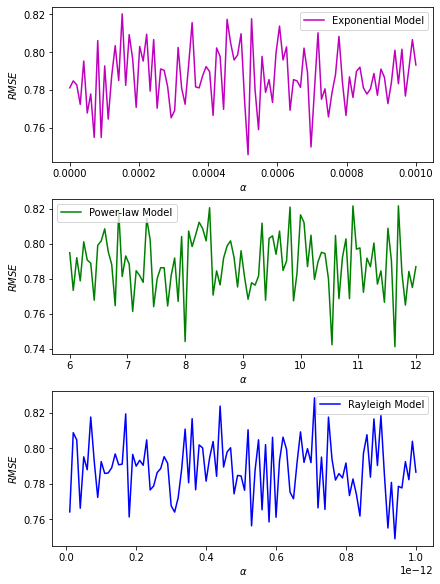

In [ ]:
fig, axs = plt.subplots(3, figsize=(6,8), constrained_layout=True)
axs[0].plot(alpha_arrange_expo, h_rmse_expo, 'm', label='Exponential Model')
axs[0].set_xlabel("$\\alpha$")
axs[0].set_ylabel('$RMSE$')
axs[0].legend()
axs[1].plot(alpha_arrange_pow, h_rmse_pow, 'g', label='Power-law Model')
axs[1].set_xlabel("$\\alpha$")
axs[1].set_ylabel('$RMSE$')
axs[1].legend(loc='upper left')
axs[2].plot(alpha_arrange_ray, h_rmse_ray, 'b', label='Rayleigh Model')
axs[2].set_xlabel("$\\alpha$")
axs[2].set_ylabel('$RMSE$')
#axs[2].set_xscale('log')
axs[2].legend()

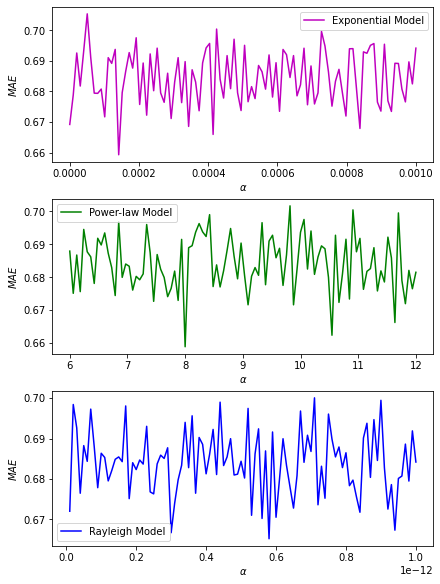

In [ ]:
fig, axs = plt.subplots(3, figsize=(6,8), constrained_layout=True)
axs[0].plot(alpha_arrange_expo, h_mae_expo, 'm', label='Exponential Model')
axs[0].set_xlabel("$\\alpha$")
axs[0].set_ylabel('$MAE$')
axs[0].legend()
axs[1].plot(alpha_arrange_pow, h_mae_pow, 'g', label='Power-law Model')
axs[1].set_xlabel("$\\alpha$")
axs[1].set_ylabel('$MAE$')
axs[1].legend(loc='upper left')
axs[2].plot(alpha_arrange_ray, h_mae_ray, 'b', label='Rayleigh Model')
axs[2].set_xlabel("$\\alpha$")
axs[2].set_ylabel('$MAE$')
#axs[2].set_xscale('log')
axs[2].legend()

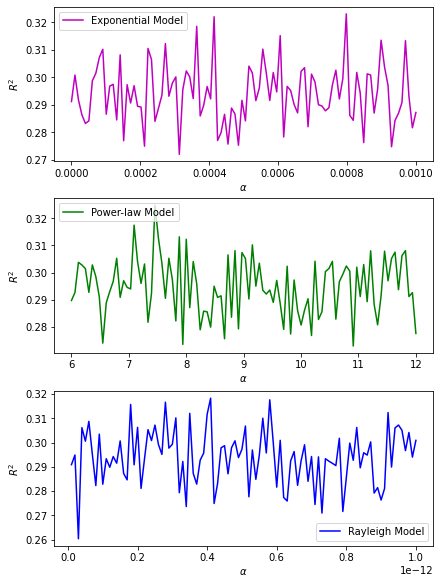

In [ ]:
fig, axs = plt.subplots(3, figsize=(6,8), constrained_layout=True)
axs[0].plot(alpha_arrange_expo, h_r2_expo, 'm', label='Exponential Model')
axs[0].set_xlabel("$\\alpha$")
axs[0].set_ylabel('$R^2$')
axs[0].legend()
axs[1].plot(alpha_arrange_pow, h_r2_pow, 'g', label='Power-law Model')
axs[1].set_xlabel("$\\alpha$")
axs[1].set_ylabel('$R^2$')
axs[1].legend(loc='upper left')
axs[2].plot(alpha_arrange_ray, h_r2_ray, 'b', label='Rayleigh Model')
axs[2].set_xlabel("$\\alpha$")
axs[2].set_ylabel('$R^2$')
#axs[2].set_xscale('log')
axs[2].legend()

In [ ]:
#True for min False por max
def get_index(type_search, x):
  index = None
  if type_search: index = min(range(len(x)), key=x.__getitem__)
  else: index = max(range(len(x)), key=x.__getitem__)
  return index

i_min_expo = get_index(True, h_rmse_expo)
i_max_expo = get_index(False, h_rmse_expo)
print(f'El RMSE minimo para el modelo exponencial es {h_rmse_expo[i_min_expo]} obtenido con el alpha {alpha_arrange_expo[i_min_expo]}')
print(f'El RMSE maximo para el modelo exponencial es {h_rmse_expo[i_max_expo]} obtenido con el alpha {alpha_arrange_expo[i_max_expo]}')
i_min_pow = get_index(True, h_rmse_pow)
i_max_pow = get_index(False, h_rmse_pow)
print(f'El RMSE minimo para el modelo power-law es {h_rmse_pow[i_min_pow]} obtenido con el alpha {alpha_arrange_pow[i_min_pow]}')
print(f'El RMSE maximo para el modelo power-law es {h_rmse_pow[i_max_pow]} obtenido con el alpha {alpha_arrange_pow[i_max_pow]}')
i_min_ray = get_index(True, h_rmse_ray)
i_max_ray = get_index(False, h_rmse_ray)
print(f'El RMSE minimo para el modelo rayleigh es {h_rmse_ray[i_min_ray]} obtenido con el alpha {alpha_arrange_ray[i_min_ray]}')
print(f'El RMSE maximo para el modelo rayleigh es {h_rmse_ray[i_max_ray]} obtenido con el alpha {alpha_arrange_ray[i_max_ray]}')
